In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image

# Parser

In [2]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="100", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-2, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default=r"C:\Users\Tianqin Li\Code\PGM-project\train_related", help="save path")
parser.add_argument("--subfolder", type=str, default=r'\baseline_st', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")


args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH]
                             [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Tianqin Li\AppData\Roaming\jupyter\runtime\kernel-c22d9554-3f25-400e-9114-2d5ec460df99.json


SystemExit: 2

C:\Users\Tianqin Li\anaconda3\envs\russ-local\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [4]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'batch_size': 400,
    'learning_rate': 1e-3,
    'momentum': 0.5,
    'gpu_num': 0,
    'seed': 123,
    'save_path': r"C:\Users\Tianqin Li\Code\PGM-project\train_related",
    'epochs': 250,
    'subfolder': r'\shffle_class_label_source_only',
    'wtarget': 0.7,
    'dann_weight': 1,
    'model_save_period': 2,
    'shuffle_weight': 1e-2,
})

In [5]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True



device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

 
model_sub_folder = args.subfolder + '\learningrate_%f_shuffle_weight_%f'%(args.learning_rate, args.shuffle_weight)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

In [6]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if os.path.isfile(args.save_path+model_sub_folder+ '\logfile.log'):
    os.remove(args.save_path+model_sub_folder+ '\logfile.log')
    
file_log_handler = logging.FileHandler(args.save_path+model_sub_folder+ '\logfile.log')
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)

attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)


batch_size: 400
learning_rate: 0.001
momentum: 0.5
gpu_num: 0
seed: 123
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
epochs: 250
subfolder: \shffle_class_label_source_only
wtarget: 0.7
dann_weight: 1
model_save_period: 2
shuffle_weight: 0.01


# Data loader

In [7]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [8]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [9]:
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\train_32x32.mat


In [10]:
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\test_32x32.mat


In [11]:
# # mnist
# train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
# test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(test_mnist_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [12]:
# # svhn
# train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(train_svhn_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [13]:
# reload data
train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)

## Process data for cancat with source and target label

In [14]:
class ConcatDataset(Dataset):
    def __init__(self, x, y, mode='mnist'):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]
        self.mode = mode
        if self.mode == 'mnist':
            self.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
        elif self.mode == 'svhn':
            self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.mode == 'mnist':
            img = Image.fromarray(self.x[index].numpy(), mode='L')
            img = self.transform(img)
        elif self.mode == 'svhn':
            img = Image.fromarray(np.transpose(self.x[index], (1, 2, 0)))
            img = self.transform(img)
    
        return img, self.y[index]

In [15]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.randint(0,2,(mnist_trainset.data.shape[0],)), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.randint(0,2,(svhn_trainset.data.shape[0],)), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [16]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [17]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [18]:
class Adversial_loss(nn.Module):
    def __init__(self):
        super(Adversial_loss, self).__init__()
    
    def forward(self):
        pass

In [19]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [20]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (ln1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

# Train

In [21]:
target_acc_label_ = []
source_acc_ = []
source_test_acc_ = []
target_test_acc_ = []

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on source domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc = source_acc / num_datas
    source_acc_.append(source_acc)
    
    # on shuffling source domain mnist
    CNet.train()
    encoder.train()
    #source_acc = 0.0
    #num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = torch.randint(0,10, (source_x.shape[0],)).to(device)
        #num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        # source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = -args.shuffle_weight * criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        

    
    
    # on target domain svhn
#     target_acc = 0.0
#     num_datas = 0.0
#     CNet.train()
#     encoder.train()

#     for batch_id, (target_x, target_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         target_x = target_x.to(device).float()
#         target_y = target_y.to(device)
#         num_datas += target_x.size(0)
#         target_x_embedding = encoder(target_x)
#         pred = CNet(target_x_embedding)
#         target_acc += (pred.argmax(-1) == target_y).sum().item()
#         loss = criterion_classifier(pred, target_y)
#         loss.backward()
#         optimizerCNet.step()
#         optimizerEncoder.step()
        
    
#     target_acc = target_acc / num_datas
#     target_acc_label_.append(target_acc)
    
    
    # DANN
#     DomainCNet.train()
#     encoder.train()
#     num_datas = 0.0
#     for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         adv_x = adv_x.to(device).float()
#         adv_y = adv_y.to(device)
#         num_datas += adv_x.size(0)
#         adv_x_embedding = encoder(adv_x)
#         pred = DomainCNet(adv_x_embedding)
#         # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
#         loss = args.dann_weight * criterion_classifier(pred, adv_y)
#         loss.backward()
#         optimizerEncoder.step()
#         optimizerDomainCNet.step()
    
    
    
    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in enumerate(test_mnist_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in enumerate(test_svhn_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(source_test_acc)
    
    if epoch % args.model_save_period == 0:
        #torch.save(DomainCNet.state_dict(), args.save_path+model_sub_folder+ '/DomainCNet_%i.t7'%(epoch+1))
        torch.save(encoder.state_dict(), args.save_path+model_sub_folder+ '/encoder_%i.t7'%(epoch+1))
        torch.save(CNet.state_dict(), args.save_path+model_sub_folder+ '/CNet_%i.t7'%(epoch+1))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, target_test_acc))
    

Started Training


100%|██████████| 150/150 [00:08<00:00, 17.69it/s]


Epochs 1: source train acc: 0.545367; source test acc: 0.877900; target test acc: 0.193934


100%|██████████| 150/150 [00:08<00:00, 17.52it/s]


Epochs 2: source train acc: 0.845750; source test acc: 0.945600; target test acc: 0.203134


100%|██████████| 150/150 [00:08<00:00, 17.54it/s]


Epochs 3: source train acc: 0.893783; source test acc: 0.962800; target test acc: 0.216403


100%|██████████| 150/150 [00:08<00:00, 17.45it/s]


Epochs 4: source train acc: 0.913583; source test acc: 0.969700; target test acc: 0.223078


100%|██████████| 150/150 [00:08<00:00, 17.50it/s]


Epochs 5: source train acc: 0.925433; source test acc: 0.973500; target test acc: 0.223173


100%|██████████| 150/150 [00:08<00:00, 17.27it/s]


Epochs 6: source train acc: 0.933183; source test acc: 0.973900; target test acc: 0.227350


100%|██████████| 150/150 [00:08<00:00, 17.44it/s]


Epochs 7: source train acc: 0.937900; source test acc: 0.976000; target test acc: 0.224920


100%|██████████| 150/150 [00:08<00:00, 17.62it/s]


Epochs 8: source train acc: 0.939400; source test acc: 0.978800; target test acc: 0.219938


100%|██████████| 150/150 [00:08<00:00, 17.27it/s]


Epochs 9: source train acc: 0.942417; source test acc: 0.973900; target test acc: 0.219692


100%|██████████| 150/150 [00:08<00:00, 17.20it/s]


Epochs 10: source train acc: 0.943417; source test acc: 0.980500; target test acc: 0.220730


100%|██████████| 150/150 [00:08<00:00, 17.56it/s]


Epochs 11: source train acc: 0.947017; source test acc: 0.977200; target test acc: 0.223201


100%|██████████| 150/150 [00:08<00:00, 17.22it/s]


Epochs 12: source train acc: 0.945833; source test acc: 0.975300; target test acc: 0.218286


100%|██████████| 150/150 [00:08<00:00, 17.69it/s]


Epochs 13: source train acc: 0.946633; source test acc: 0.972500; target test acc: 0.214669


100%|██████████| 150/150 [00:08<00:00, 17.15it/s]


Epochs 14: source train acc: 0.946383; source test acc: 0.969900; target test acc: 0.216225


100%|██████████| 150/150 [00:08<00:00, 17.32it/s]


Epochs 15: source train acc: 0.944650; source test acc: 0.961600; target test acc: 0.217549


100%|██████████| 150/150 [00:08<00:00, 17.00it/s]


Epochs 16: source train acc: 0.945417; source test acc: 0.962800; target test acc: 0.214901


100%|██████████| 150/150 [00:08<00:00, 16.99it/s]


Epochs 17: source train acc: 0.944033; source test acc: 0.964000; target test acc: 0.220894


100%|██████████| 150/150 [00:08<00:00, 17.29it/s]


Epochs 18: source train acc: 0.944750; source test acc: 0.961000; target test acc: 0.219788


100%|██████████| 150/150 [00:08<00:00, 17.07it/s]


Epochs 19: source train acc: 0.944383; source test acc: 0.945500; target test acc: 0.222068


100%|██████████| 150/150 [00:08<00:00, 17.05it/s]


Epochs 20: source train acc: 0.941517; source test acc: 0.958700; target test acc: 0.228934


100%|██████████| 150/150 [00:08<00:00, 17.06it/s]


Epochs 21: source train acc: 0.940717; source test acc: 0.957400; target test acc: 0.227023


100%|██████████| 150/150 [00:08<00:00, 16.87it/s]


Epochs 22: source train acc: 0.940050; source test acc: 0.951900; target test acc: 0.231582


100%|██████████| 150/150 [00:08<00:00, 16.88it/s]


Epochs 23: source train acc: 0.941017; source test acc: 0.910700; target test acc: 0.219078


100%|██████████| 150/150 [00:08<00:00, 17.58it/s]


Epochs 24: source train acc: 0.930700; source test acc: 0.966000; target test acc: 0.235636


100%|██████████| 150/150 [00:08<00:00, 17.85it/s]


Epochs 25: source train acc: 0.933400; source test acc: 0.961100; target test acc: 0.229985


100%|██████████| 150/150 [00:08<00:00, 17.81it/s]


Epochs 26: source train acc: 0.934083; source test acc: 0.959900; target test acc: 0.244318


100%|██████████| 150/150 [00:08<00:00, 17.33it/s]


Epochs 27: source train acc: 0.934217; source test acc: 0.951700; target test acc: 0.233397


100%|██████████| 150/150 [00:08<00:00, 17.68it/s]


Epochs 28: source train acc: 0.931600; source test acc: 0.959400; target test acc: 0.234408


100%|██████████| 150/150 [00:08<00:00, 17.60it/s]


Epochs 29: source train acc: 0.931317; source test acc: 0.948500; target test acc: 0.228470


100%|██████████| 150/150 [00:08<00:00, 17.73it/s]


Epochs 30: source train acc: 0.922950; source test acc: 0.965400; target test acc: 0.229057


100%|██████████| 150/150 [00:08<00:00, 17.70it/s]


Epochs 31: source train acc: 0.928233; source test acc: 0.960300; target test acc: 0.226354


100%|██████████| 150/150 [00:08<00:00, 17.61it/s]


Epochs 32: source train acc: 0.927933; source test acc: 0.954300; target test acc: 0.225084


100%|██████████| 150/150 [00:08<00:00, 17.95it/s]


Epochs 33: source train acc: 0.917367; source test acc: 0.960900; target test acc: 0.219911


100%|██████████| 150/150 [00:08<00:00, 18.16it/s]


Epochs 34: source train acc: 0.908267; source test acc: 0.959900; target test acc: 0.228565


100%|██████████| 150/150 [00:08<00:00, 17.60it/s]


Epochs 35: source train acc: 0.916467; source test acc: 0.960800; target test acc: 0.226436


100%|██████████| 150/150 [00:08<00:00, 17.70it/s]


Epochs 36: source train acc: 0.910667; source test acc: 0.964100; target test acc: 0.234244


100%|██████████| 150/150 [00:08<00:00, 17.71it/s]


Epochs 37: source train acc: 0.915950; source test acc: 0.954600; target test acc: 0.234449


100%|██████████| 150/150 [00:08<00:00, 16.82it/s]


Epochs 38: source train acc: 0.896983; source test acc: 0.958700; target test acc: 0.229998


100%|██████████| 150/150 [00:08<00:00, 16.70it/s]


Epochs 39: source train acc: 0.912600; source test acc: 0.962100; target test acc: 0.226995


100%|██████████| 150/150 [00:09<00:00, 16.25it/s]


Epochs 40: source train acc: 0.916000; source test acc: 0.962800; target test acc: 0.225125


100%|██████████| 150/150 [00:08<00:00, 16.91it/s]


Epochs 41: source train acc: 0.914917; source test acc: 0.969600; target test acc: 0.224129


100%|██████████| 150/150 [00:08<00:00, 17.11it/s]


Epochs 42: source train acc: 0.900667; source test acc: 0.970000; target test acc: 0.222545


100%|██████████| 150/150 [00:08<00:00, 16.99it/s]


Epochs 43: source train acc: 0.905050; source test acc: 0.102800; target test acc: 0.076375


100%|██████████| 150/150 [00:08<00:00, 16.83it/s]


Epochs 44: source train acc: 0.725983; source test acc: 0.670800; target test acc: 0.194998


100%|██████████| 150/150 [00:08<00:00, 16.68it/s]


Epochs 45: source train acc: 0.795017; source test acc: 0.925200; target test acc: 0.215433


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


Epochs 46: source train acc: 0.867317; source test acc: 0.946200; target test acc: 0.228238


100%|██████████| 150/150 [00:09<00:00, 16.44it/s]


Epochs 47: source train acc: 0.885350; source test acc: 0.950600; target test acc: 0.228456


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


Epochs 48: source train acc: 0.882883; source test acc: 0.960400; target test acc: 0.229452


100%|██████████| 150/150 [00:09<00:00, 16.61it/s]


Epochs 49: source train acc: 0.895233; source test acc: 0.963800; target test acc: 0.223378


100%|██████████| 150/150 [00:09<00:00, 16.63it/s]


Epochs 50: source train acc: 0.894667; source test acc: 0.968400; target test acc: 0.228592


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 51: source train acc: 0.896050; source test acc: 0.974200; target test acc: 0.230585


100%|██████████| 150/150 [00:09<00:00, 16.62it/s]


Epochs 52: source train acc: 0.887633; source test acc: 0.972700; target test acc: 0.216607


100%|██████████| 150/150 [00:09<00:00, 16.14it/s]


Epochs 53: source train acc: 0.888600; source test acc: 0.970100; target test acc: 0.209045


100%|██████████| 150/150 [00:09<00:00, 16.48it/s]


Epochs 54: source train acc: 0.887383; source test acc: 0.972000; target test acc: 0.217331


100%|██████████| 150/150 [00:08<00:00, 17.01it/s]


Epochs 55: source train acc: 0.900683; source test acc: 0.971100; target test acc: 0.221153


100%|██████████| 150/150 [00:09<00:00, 16.58it/s]


Epochs 56: source train acc: 0.895717; source test acc: 0.973700; target test acc: 0.224634


100%|██████████| 150/150 [00:09<00:00, 16.60it/s]


Epochs 57: source train acc: 0.901183; source test acc: 0.971000; target test acc: 0.221740


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


Epochs 58: source train acc: 0.888000; source test acc: 0.969900; target test acc: 0.224088


100%|██████████| 150/150 [00:08<00:00, 16.69it/s]


Epochs 59: source train acc: 0.899800; source test acc: 0.974700; target test acc: 0.212703


100%|██████████| 150/150 [00:09<00:00, 15.76it/s]


Epochs 60: source train acc: 0.902050; source test acc: 0.973800; target test acc: 0.209277


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 61: source train acc: 0.876600; source test acc: 0.973500; target test acc: 0.215624


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 62: source train acc: 0.881117; source test acc: 0.976100; target test acc: 0.216034


100%|██████████| 150/150 [00:09<00:00, 16.06it/s]


Epochs 63: source train acc: 0.889917; source test acc: 0.973800; target test acc: 0.232087


100%|██████████| 150/150 [00:09<00:00, 16.57it/s]


Epochs 64: source train acc: 0.890467; source test acc: 0.971400; target test acc: 0.226313


100%|██████████| 150/150 [00:09<00:00, 15.74it/s]


Epochs 65: source train acc: 0.886867; source test acc: 0.973100; target test acc: 0.238817


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 66: source train acc: 0.899933; source test acc: 0.977100; target test acc: 0.232756


100%|██████████| 150/150 [00:08<00:00, 17.05it/s]


Epochs 67: source train acc: 0.890917; source test acc: 0.968200; target test acc: 0.192200


100%|██████████| 150/150 [00:09<00:00, 16.65it/s]


Epochs 68: source train acc: 0.880817; source test acc: 0.966000; target test acc: 0.216102


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 69: source train acc: 0.879700; source test acc: 0.972200; target test acc: 0.227159


100%|██████████| 150/150 [00:09<00:00, 16.08it/s]


Epochs 70: source train acc: 0.872350; source test acc: 0.970200; target test acc: 0.222422


100%|██████████| 150/150 [00:08<00:00, 16.81it/s]


Epochs 71: source train acc: 0.889883; source test acc: 0.965900; target test acc: 0.218628


100%|██████████| 150/150 [00:09<00:00, 15.81it/s]


Epochs 72: source train acc: 0.847183; source test acc: 0.967900; target test acc: 0.223487


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 73: source train acc: 0.887733; source test acc: 0.975100; target test acc: 0.222231


100%|██████████| 150/150 [00:09<00:00, 16.53it/s]


Epochs 74: source train acc: 0.868983; source test acc: 0.975500; target test acc: 0.215133


100%|██████████| 150/150 [00:09<00:00, 16.26it/s]


Epochs 75: source train acc: 0.872900; source test acc: 0.973100; target test acc: 0.214519


100%|██████████| 150/150 [00:09<00:00, 16.34it/s]


Epochs 76: source train acc: 0.873667; source test acc: 0.976900; target test acc: 0.206520


100%|██████████| 150/150 [00:09<00:00, 16.47it/s]


Epochs 77: source train acc: 0.873117; source test acc: 0.957500; target test acc: 0.230463


100%|██████████| 150/150 [00:09<00:00, 16.58it/s]


Epochs 78: source train acc: 0.878800; source test acc: 0.969800; target test acc: 0.207311


100%|██████████| 150/150 [00:09<00:00, 16.30it/s]


Epochs 79: source train acc: 0.884850; source test acc: 0.978700; target test acc: 0.215857


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 80: source train acc: 0.890467; source test acc: 0.974200; target test acc: 0.196773


100%|██████████| 150/150 [00:09<00:00, 16.51it/s]


Epochs 81: source train acc: 0.859383; source test acc: 0.944600; target test acc: 0.213440


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 82: source train acc: 0.852133; source test acc: 0.968000; target test acc: 0.195763


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 83: source train acc: 0.865617; source test acc: 0.928400; target test acc: 0.193947


100%|██████████| 150/150 [00:09<00:00, 16.53it/s]


Epochs 84: source train acc: 0.877150; source test acc: 0.969900; target test acc: 0.209072


100%|██████████| 150/150 [00:09<00:00, 16.08it/s]


Epochs 85: source train acc: 0.854317; source test acc: 0.971200; target test acc: 0.213904


100%|██████████| 150/150 [00:09<00:00, 16.34it/s]


Epochs 86: source train acc: 0.859317; source test acc: 0.958500; target test acc: 0.209468


100%|██████████| 150/150 [00:09<00:00, 16.38it/s]


Epochs 87: source train acc: 0.882383; source test acc: 0.938800; target test acc: 0.207857


100%|██████████| 150/150 [00:09<00:00, 16.32it/s]


Epochs 88: source train acc: 0.878167; source test acc: 0.881100; target test acc: 0.213509


100%|██████████| 150/150 [00:09<00:00, 15.48it/s]


Epochs 89: source train acc: 0.874667; source test acc: 0.887800; target test acc: 0.220102


100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


Epochs 90: source train acc: 0.866917; source test acc: 0.940500; target test acc: 0.209919


100%|██████████| 150/150 [00:08<00:00, 16.69it/s]


Epochs 91: source train acc: 0.861000; source test acc: 0.977100; target test acc: 0.213591


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 92: source train acc: 0.868550; source test acc: 0.965900; target test acc: 0.218641


100%|██████████| 150/150 [00:09<00:00, 16.42it/s]


Epochs 93: source train acc: 0.884433; source test acc: 0.973200; target test acc: 0.213427


100%|██████████| 150/150 [00:09<00:00, 16.56it/s]


Epochs 94: source train acc: 0.883000; source test acc: 0.974600; target test acc: 0.210942


100%|██████████| 150/150 [00:09<00:00, 16.13it/s]


Epochs 95: source train acc: 0.855033; source test acc: 0.974900; target test acc: 0.216020


100%|██████████| 150/150 [00:09<00:00, 16.45it/s]


Epochs 96: source train acc: 0.860033; source test acc: 0.963900; target test acc: 0.205086


100%|██████████| 150/150 [00:09<00:00, 15.74it/s]


Epochs 97: source train acc: 0.867500; source test acc: 0.975300; target test acc: 0.213672


100%|██████████| 150/150 [00:09<00:00, 15.08it/s]


Epochs 98: source train acc: 0.867367; source test acc: 0.975400; target test acc: 0.170646


100%|██████████| 150/150 [00:09<00:00, 16.02it/s]


Epochs 99: source train acc: 0.874367; source test acc: 0.888000; target test acc: 0.210096


100%|██████████| 150/150 [00:10<00:00, 14.72it/s]


Epochs 100: source train acc: 0.848700; source test acc: 0.974000; target test acc: 0.206328


100%|██████████| 150/150 [00:10<00:00, 14.89it/s]


Epochs 101: source train acc: 0.847333; source test acc: 0.966200; target test acc: 0.137461


100%|██████████| 150/150 [00:09<00:00, 15.73it/s]


Epochs 102: source train acc: 0.867983; source test acc: 0.971600; target test acc: 0.212949


100%|██████████| 150/150 [00:10<00:00, 14.96it/s]


Epochs 103: source train acc: 0.876883; source test acc: 0.931700; target test acc: 0.156231


100%|██████████| 150/150 [00:09<00:00, 15.11it/s]


Epochs 104: source train acc: 0.876083; source test acc: 0.902700; target test acc: 0.169827


100%|██████████| 150/150 [00:09<00:00, 15.59it/s]


Epochs 105: source train acc: 0.872767; source test acc: 0.887300; target test acc: 0.204294


100%|██████████| 150/150 [00:09<00:00, 15.18it/s]


Epochs 106: source train acc: 0.821783; source test acc: 0.963500; target test acc: 0.210929


100%|██████████| 150/150 [00:09<00:00, 15.22it/s]


Epochs 107: source train acc: 0.872000; source test acc: 0.897100; target test acc: 0.184638


100%|██████████| 150/150 [00:10<00:00, 14.69it/s]


Epochs 108: source train acc: 0.811900; source test acc: 0.919500; target test acc: 0.172106


100%|██████████| 150/150 [00:09<00:00, 15.07it/s]


Epochs 109: source train acc: 0.851200; source test acc: 0.888000; target test acc: 0.150429


100%|██████████| 150/150 [00:10<00:00, 15.00it/s]


Epochs 110: source train acc: 0.856083; source test acc: 0.970400; target test acc: 0.161363


100%|██████████| 150/150 [00:09<00:00, 15.10it/s]


Epochs 111: source train acc: 0.847517; source test acc: 0.905400; target test acc: 0.212034


100%|██████████| 150/150 [00:09<00:00, 15.64it/s]


Epochs 112: source train acc: 0.853817; source test acc: 0.973500; target test acc: 0.207598


100%|██████████| 150/150 [00:10<00:00, 14.84it/s]


Epochs 113: source train acc: 0.852267; source test acc: 0.910300; target test acc: 0.202957


100%|██████████| 150/150 [00:09<00:00, 15.04it/s]


Epochs 114: source train acc: 0.870650; source test acc: 0.974800; target test acc: 0.205223


100%|██████████| 150/150 [00:09<00:00, 15.41it/s]


Epochs 115: source train acc: 0.841383; source test acc: 0.976700; target test acc: 0.169322


100%|██████████| 150/150 [00:09<00:00, 15.05it/s]


Epochs 116: source train acc: 0.859217; source test acc: 0.976100; target test acc: 0.152627


100%|██████████| 150/150 [00:09<00:00, 15.11it/s]


Epochs 117: source train acc: 0.835817; source test acc: 0.942400; target test acc: 0.168216


100%|██████████| 150/150 [00:10<00:00, 14.13it/s]


Epochs 118: source train acc: 0.859133; source test acc: 0.886100; target test acc: 0.210792


100%|██████████| 150/150 [00:10<00:00, 14.79it/s]


Epochs 119: source train acc: 0.844967; source test acc: 0.962900; target test acc: 0.207352


100%|██████████| 150/150 [00:09<00:00, 15.14it/s]


Epochs 120: source train acc: 0.854217; source test acc: 0.859700; target test acc: 0.179805


100%|██████████| 150/150 [00:09<00:00, 15.09it/s]


Epochs 121: source train acc: 0.846667; source test acc: 0.957400; target test acc: 0.174727


100%|██████████| 150/150 [00:10<00:00, 14.85it/s]


Epochs 122: source train acc: 0.844017; source test acc: 0.960900; target test acc: 0.205564


100%|██████████| 150/150 [00:09<00:00, 15.26it/s]


Epochs 123: source train acc: 0.867300; source test acc: 0.888300; target test acc: 0.158456


100%|██████████| 150/150 [00:09<00:00, 15.21it/s]


Epochs 124: source train acc: 0.846717; source test acc: 0.913000; target test acc: 0.204131


100%|██████████| 150/150 [00:10<00:00, 14.96it/s]


Epochs 125: source train acc: 0.846700; source test acc: 0.879300; target test acc: 0.157978


100%|██████████| 150/150 [00:11<00:00, 13.47it/s]


Epochs 126: source train acc: 0.857683; source test acc: 0.969100; target test acc: 0.161650


100%|██████████| 150/150 [00:10<00:00, 14.27it/s]


Epochs 127: source train acc: 0.860117; source test acc: 0.935500; target test acc: 0.209113


100%|██████████| 150/150 [00:10<00:00, 14.84it/s]


Epochs 128: source train acc: 0.872400; source test acc: 0.918500; target test acc: 0.158442


100%|██████████| 150/150 [00:10<00:00, 14.79it/s]


Epochs 129: source train acc: 0.861317; source test acc: 0.886100; target test acc: 0.206820


100%|██████████| 150/150 [00:10<00:00, 14.68it/s]


Epochs 130: source train acc: 0.851333; source test acc: 0.885100; target test acc: 0.210096


100%|██████████| 150/150 [00:10<00:00, 14.87it/s]


Epochs 131: source train acc: 0.849167; source test acc: 0.967900; target test acc: 0.198643


100%|██████████| 150/150 [00:09<00:00, 15.08it/s]


Epochs 132: source train acc: 0.853800; source test acc: 0.881100; target test acc: 0.143795


100%|██████████| 150/150 [00:09<00:00, 15.62it/s]


Epochs 133: source train acc: 0.865200; source test acc: 0.969600; target test acc: 0.159002


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 134: source train acc: 0.846283; source test acc: 0.922700; target test acc: 0.166482


100%|██████████| 150/150 [00:09<00:00, 16.29it/s]


Epochs 135: source train acc: 0.854900; source test acc: 0.881400; target test acc: 0.147904


100%|██████████| 150/150 [00:09<00:00, 15.64it/s]


Epochs 136: source train acc: 0.847283; source test acc: 0.905500; target test acc: 0.211638


100%|██████████| 150/150 [00:09<00:00, 16.50it/s]


Epochs 137: source train acc: 0.851117; source test acc: 0.946300; target test acc: 0.207257


100%|██████████| 150/150 [00:09<00:00, 16.28it/s]


Epochs 138: source train acc: 0.845850; source test acc: 0.893400; target test acc: 0.145774


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 139: source train acc: 0.860600; source test acc: 0.973800; target test acc: 0.162742


100%|██████████| 150/150 [00:09<00:00, 16.66it/s]


Epochs 140: source train acc: 0.862500; source test acc: 0.944000; target test acc: 0.151221


100%|██████████| 150/150 [00:09<00:00, 16.21it/s]


Epochs 141: source train acc: 0.833100; source test acc: 0.880500; target test acc: 0.202424


100%|██████████| 150/150 [00:08<00:00, 16.85it/s]


Epochs 142: source train acc: 0.849900; source test acc: 0.943100; target test acc: 0.159466


100%|██████████| 150/150 [00:09<00:00, 16.67it/s]


Epochs 143: source train acc: 0.857533; source test acc: 0.912800; target test acc: 0.161650


100%|██████████| 150/150 [00:09<00:00, 16.03it/s]


Epochs 144: source train acc: 0.846700; source test acc: 0.923900; target test acc: 0.155139


100%|██████████| 150/150 [00:08<00:00, 16.67it/s]


Epochs 145: source train acc: 0.860233; source test acc: 0.919200; target test acc: 0.149078


100%|██████████| 150/150 [00:09<00:00, 16.19it/s]


Epochs 146: source train acc: 0.843450; source test acc: 0.871200; target test acc: 0.153569


100%|██████████| 150/150 [00:09<00:00, 16.00it/s]


Epochs 147: source train acc: 0.852700; source test acc: 0.951900; target test acc: 0.204813


100%|██████████| 150/150 [00:09<00:00, 16.34it/s]


Epochs 148: source train acc: 0.840033; source test acc: 0.965500; target test acc: 0.209659


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 149: source train acc: 0.850550; source test acc: 0.820300; target test acc: 0.163274


100%|██████████| 150/150 [00:09<00:00, 15.88it/s]


Epochs 150: source train acc: 0.857467; source test acc: 0.834100; target test acc: 0.204786


100%|██████████| 150/150 [00:09<00:00, 16.05it/s]


Epochs 151: source train acc: 0.835400; source test acc: 0.916000; target test acc: 0.211775


100%|██████████| 150/150 [00:09<00:00, 16.41it/s]


Epochs 152: source train acc: 0.840317; source test acc: 0.876700; target test acc: 0.140082


100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


Epochs 153: source train acc: 0.848450; source test acc: 0.957300; target test acc: 0.155794


100%|██████████| 150/150 [00:09<00:00, 16.06it/s]


Epochs 154: source train acc: 0.832733; source test acc: 0.860000; target test acc: 0.171451


100%|██████████| 150/150 [00:08<00:00, 16.96it/s]


Epochs 155: source train acc: 0.844100; source test acc: 0.918500; target test acc: 0.163971


100%|██████████| 150/150 [00:09<00:00, 16.18it/s]


Epochs 156: source train acc: 0.854783; source test acc: 0.934600; target test acc: 0.147017


100%|██████████| 150/150 [00:09<00:00, 16.18it/s]


Epochs 157: source train acc: 0.838650; source test acc: 0.964600; target test acc: 0.217153


100%|██████████| 150/150 [00:08<00:00, 16.89it/s]


Epochs 158: source train acc: 0.851967; source test acc: 0.956800; target test acc: 0.158688


100%|██████████| 150/150 [00:09<00:00, 16.18it/s]


Epochs 159: source train acc: 0.831617; source test acc: 0.818600; target test acc: 0.146143


100%|██████████| 150/150 [00:09<00:00, 15.94it/s]


Epochs 160: source train acc: 0.823033; source test acc: 0.951900; target test acc: 0.124493


100%|██████████| 150/150 [00:08<00:00, 16.76it/s]


Epochs 161: source train acc: 0.850150; source test acc: 0.890900; target test acc: 0.131196


100%|██████████| 150/150 [00:09<00:00, 16.32it/s]


Epochs 162: source train acc: 0.846617; source test acc: 0.882300; target test acc: 0.141625


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 163: source train acc: 0.831517; source test acc: 0.958300; target test acc: 0.123934


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 164: source train acc: 0.839883; source test acc: 0.873700; target test acc: 0.155630


100%|██████████| 150/150 [00:09<00:00, 16.58it/s]


Epochs 165: source train acc: 0.852567; source test acc: 0.935100; target test acc: 0.205114


100%|██████████| 150/150 [00:09<00:00, 16.15it/s]


Epochs 166: source train acc: 0.840200; source test acc: 0.897100; target test acc: 0.141488


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 167: source train acc: 0.855917; source test acc: 0.888500; target test acc: 0.142512


100%|██████████| 150/150 [00:09<00:00, 16.61it/s]


Epochs 168: source train acc: 0.838350; source test acc: 0.951800; target test acc: 0.208280


100%|██████████| 150/150 [00:09<00:00, 15.98it/s]


Epochs 169: source train acc: 0.815717; source test acc: 0.865600; target test acc: 0.144287


100%|██████████| 150/150 [00:09<00:00, 16.45it/s]


Epochs 170: source train acc: 0.821267; source test acc: 0.889000; target test acc: 0.162483


100%|██████████| 150/150 [00:08<00:00, 16.78it/s]


Epochs 171: source train acc: 0.838367; source test acc: 0.873300; target test acc: 0.140041


100%|██████████| 150/150 [00:09<00:00, 16.06it/s]


Epochs 172: source train acc: 0.844600; source test acc: 0.893600; target test acc: 0.153187


100%|██████████| 150/150 [00:09<00:00, 16.35it/s]


Epochs 173: source train acc: 0.834233; source test acc: 0.874900; target test acc: 0.206642


100%|██████████| 150/150 [00:08<00:00, 16.72it/s]


Epochs 174: source train acc: 0.836933; source test acc: 0.803900; target test acc: 0.160340


100%|██████████| 150/150 [00:09<00:00, 16.00it/s]


Epochs 175: source train acc: 0.829483; source test acc: 0.792900; target test acc: 0.167588


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 176: source train acc: 0.806767; source test acc: 0.961700; target test acc: 0.199803


100%|██████████| 150/150 [00:08<00:00, 17.08it/s]


Epochs 177: source train acc: 0.807833; source test acc: 0.847100; target test acc: 0.150006


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 178: source train acc: 0.817750; source test acc: 0.937300; target test acc: 0.153637


100%|██████████| 150/150 [00:09<00:00, 16.19it/s]


Epochs 179: source train acc: 0.830250; source test acc: 0.787200; target test acc: 0.145215


100%|██████████| 150/150 [00:08<00:00, 16.97it/s]


Epochs 180: source train acc: 0.825917; source test acc: 0.963600; target test acc: 0.123265


100%|██████████| 150/150 [00:09<00:00, 16.38it/s]


Epochs 181: source train acc: 0.832000; source test acc: 0.961900; target test acc: 0.131974


100%|██████████| 150/150 [00:09<00:00, 16.34it/s]


Epochs 182: source train acc: 0.833417; source test acc: 0.863600; target test acc: 0.136124


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


Epochs 183: source train acc: 0.814433; source test acc: 0.789100; target test acc: 0.117477


100%|██████████| 150/150 [00:09<00:00, 16.34it/s]


Epochs 184: source train acc: 0.831483; source test acc: 0.882900; target test acc: 0.121995


100%|██████████| 150/150 [00:09<00:00, 16.11it/s]


Epochs 185: source train acc: 0.832650; source test acc: 0.950100; target test acc: 0.147413


100%|██████████| 150/150 [00:08<00:00, 16.71it/s]


Epochs 186: source train acc: 0.817583; source test acc: 0.858200; target test acc: 0.144450


100%|██████████| 150/150 [00:09<00:00, 16.28it/s]


Epochs 187: source train acc: 0.836350; source test acc: 0.843800; target test acc: 0.145802


100%|██████████| 150/150 [00:09<00:00, 16.07it/s]


Epochs 188: source train acc: 0.822267; source test acc: 0.915600; target test acc: 0.131018


100%|██████████| 150/150 [00:09<00:00, 16.33it/s]


Epochs 189: source train acc: 0.841467; source test acc: 0.961100; target test acc: 0.159971


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 190: source train acc: 0.832433; source test acc: 0.886800; target test acc: 0.125927


100%|██████████| 150/150 [00:09<00:00, 16.08it/s]


Epochs 191: source train acc: 0.838250; source test acc: 0.835700; target test acc: 0.129844


100%|██████████| 150/150 [00:09<00:00, 15.93it/s]


Epochs 192: source train acc: 0.810350; source test acc: 0.868000; target test acc: 0.128042


100%|██████████| 150/150 [00:09<00:00, 16.09it/s]


Epochs 193: source train acc: 0.839633; source test acc: 0.900100; target test acc: 0.137570


100%|██████████| 150/150 [00:09<00:00, 15.39it/s]


Epochs 194: source train acc: 0.820317; source test acc: 0.788200; target test acc: 0.139891


100%|██████████| 150/150 [00:09<00:00, 16.01it/s]


Epochs 195: source train acc: 0.828367; source test acc: 0.870500; target test acc: 0.144014


100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Epochs 196: source train acc: 0.825583; source test acc: 0.871500; target test acc: 0.150730


100%|██████████| 150/150 [00:09<00:00, 15.99it/s]


Epochs 197: source train acc: 0.823467; source test acc: 0.938400; target test acc: 0.134035


100%|██████████| 150/150 [00:09<00:00, 16.41it/s]


Epochs 198: source train acc: 0.836083; source test acc: 0.824900; target test acc: 0.154402


100%|██████████| 150/150 [00:08<00:00, 16.75it/s]


Epochs 199: source train acc: 0.827233; source test acc: 0.796300; target test acc: 0.132806


100%|██████████| 150/150 [00:09<00:00, 16.41it/s]


Epochs 200: source train acc: 0.828167; source test acc: 0.865500; target test acc: 0.160449


100%|██████████| 150/150 [00:09<00:00, 16.25it/s]


Epochs 201: source train acc: 0.838600; source test acc: 0.951900; target test acc: 0.143099


100%|██████████| 150/150 [00:09<00:00, 16.60it/s]


Epochs 202: source train acc: 0.828233; source test acc: 0.969400; target test acc: 0.205004


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 203: source train acc: 0.825417; source test acc: 0.762100; target test acc: 0.148341


100%|██████████| 150/150 [00:09<00:00, 16.03it/s]


Epochs 204: source train acc: 0.818683; source test acc: 0.814000; target test acc: 0.149665


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 205: source train acc: 0.831850; source test acc: 0.829700; target test acc: 0.195367


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 206: source train acc: 0.819600; source test acc: 0.789700; target test acc: 0.199476


100%|██████████| 150/150 [00:09<00:00, 15.76it/s]


Epochs 207: source train acc: 0.835767; source test acc: 0.869100; target test acc: 0.197578


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 208: source train acc: 0.817233; source test acc: 0.794500; target test acc: 0.135523


100%|██████████| 150/150 [00:09<00:00, 16.10it/s]


Epochs 209: source train acc: 0.809933; source test acc: 0.865700; target test acc: 0.137489


100%|██████████| 150/150 [00:09<00:00, 16.01it/s]


Epochs 210: source train acc: 0.837183; source test acc: 0.872400; target test acc: 0.144205


100%|██████████| 150/150 [00:09<00:00, 16.20it/s]


Epochs 211: source train acc: 0.832400; source test acc: 0.859200; target test acc: 0.154088


100%|██████████| 150/150 [00:09<00:00, 16.23it/s]


Epochs 212: source train acc: 0.794550; source test acc: 0.947400; target test acc: 0.120903


100%|██████████| 150/150 [00:09<00:00, 16.24it/s]


Epochs 213: source train acc: 0.792150; source test acc: 0.818600; target test acc: 0.132452


100%|██████████| 150/150 [00:09<00:00, 16.55it/s]


Epochs 214: source train acc: 0.814483; source test acc: 0.776700; target test acc: 0.145488


100%|██████████| 150/150 [00:09<00:00, 15.87it/s]


Epochs 215: source train acc: 0.797133; source test acc: 0.874300; target test acc: 0.149487


100%|██████████| 150/150 [00:09<00:00, 16.49it/s]


Epochs 216: source train acc: 0.823667; source test acc: 0.767300; target test acc: 0.141475


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 217: source train acc: 0.819550; source test acc: 0.826600; target test acc: 0.148136


100%|██████████| 150/150 [00:09<00:00, 15.67it/s]


Epochs 218: source train acc: 0.812067; source test acc: 0.665800; target test acc: 0.160326


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 219: source train acc: 0.812850; source test acc: 0.778300; target test acc: 0.161677


100%|██████████| 150/150 [00:09<00:00, 16.41it/s]


Epochs 220: source train acc: 0.824983; source test acc: 0.781300; target test acc: 0.144014


100%|██████████| 150/150 [00:09<00:00, 16.00it/s]


Epochs 221: source train acc: 0.814400; source test acc: 0.731300; target test acc: 0.155603


100%|██████████| 150/150 [00:09<00:00, 16.54it/s]


Epochs 222: source train acc: 0.821667; source test acc: 0.767000; target test acc: 0.206574


100%|██████████| 150/150 [00:09<00:00, 16.48it/s]


Epochs 223: source train acc: 0.822333; source test acc: 0.867000; target test acc: 0.132056


100%|██████████| 150/150 [00:09<00:00, 16.25it/s]


Epochs 224: source train acc: 0.826417; source test acc: 0.783100; target test acc: 0.141379


100%|██████████| 150/150 [00:09<00:00, 16.31it/s]


Epochs 225: source train acc: 0.831817; source test acc: 0.878300; target test acc: 0.137857


100%|██████████| 150/150 [00:08<00:00, 17.71it/s]


Epochs 226: source train acc: 0.824550; source test acc: 0.809200; target test acc: 0.207202


100%|██████████| 150/150 [00:08<00:00, 17.40it/s]


Epochs 227: source train acc: 0.767917; source test acc: 0.772700; target test acc: 0.128111


100%|██████████| 150/150 [00:08<00:00, 17.59it/s]


Epochs 228: source train acc: 0.822300; source test acc: 0.952400; target test acc: 0.199831


100%|██████████| 150/150 [00:08<00:00, 17.93it/s]


Epochs 229: source train acc: 0.828533; source test acc: 0.682200; target test acc: 0.149528


100%|██████████| 150/150 [00:08<00:00, 17.61it/s]


Epochs 230: source train acc: 0.813850; source test acc: 0.838600; target test acc: 0.124671


100%|██████████| 150/150 [00:08<00:00, 17.04it/s]


Epochs 231: source train acc: 0.825583; source test acc: 0.771600; target test acc: 0.121108


100%|██████████| 150/150 [00:08<00:00, 18.01it/s]


Epochs 232: source train acc: 0.824017; source test acc: 0.792700; target test acc: 0.120821


100%|██████████| 150/150 [00:08<00:00, 17.42it/s]


Epochs 233: source train acc: 0.810850; source test acc: 0.776400; target test acc: 0.132847


100%|██████████| 150/150 [00:08<00:00, 17.24it/s]


Epochs 234: source train acc: 0.791167; source test acc: 0.745000; target test acc: 0.205673


100%|██████████| 150/150 [00:08<00:00, 17.99it/s]


Epochs 235: source train acc: 0.819100; source test acc: 0.721000; target test acc: 0.162469


100%|██████████| 150/150 [00:08<00:00, 17.45it/s]


Epochs 236: source train acc: 0.811783; source test acc: 0.865100; target test acc: 0.167015


100%|██████████| 150/150 [00:08<00:00, 17.18it/s]


Epochs 237: source train acc: 0.829183; source test acc: 0.881300; target test acc: 0.167056


100%|██████████| 150/150 [00:08<00:00, 17.82it/s]


Epochs 238: source train acc: 0.814617; source test acc: 0.812500; target test acc: 0.166428


100%|██████████| 150/150 [00:08<00:00, 17.73it/s]


Epochs 239: source train acc: 0.827433; source test acc: 0.681100; target test acc: 0.153446


100%|██████████| 150/150 [00:08<00:00, 17.01it/s]


Epochs 240: source train acc: 0.821817; source test acc: 0.779800; target test acc: 0.144887


100%|██████████| 150/150 [00:08<00:00, 17.56it/s]


Epochs 241: source train acc: 0.804317; source test acc: 0.774400; target test acc: 0.129639


100%|██████████| 150/150 [00:08<00:00, 17.47it/s]


Epochs 242: source train acc: 0.795750; source test acc: 0.856200; target test acc: 0.132397


100%|██████████| 150/150 [00:08<00:00, 17.07it/s]


Epochs 243: source train acc: 0.827483; source test acc: 0.690400; target test acc: 0.138703


100%|██████████| 150/150 [00:08<00:00, 17.62it/s]


Epochs 244: source train acc: 0.820867; source test acc: 0.949400; target test acc: 0.158169


100%|██████████| 150/150 [00:08<00:00, 17.55it/s]


Epochs 245: source train acc: 0.818550; source test acc: 0.965200; target test acc: 0.138035


100%|██████████| 150/150 [00:08<00:00, 16.99it/s]


Epochs 246: source train acc: 0.825983; source test acc: 0.681400; target test acc: 0.204144


100%|██████████| 150/150 [00:08<00:00, 17.24it/s]


Epochs 247: source train acc: 0.807133; source test acc: 0.776200; target test acc: 0.159876


100%|██████████| 150/150 [00:08<00:00, 17.92it/s]


Epochs 248: source train acc: 0.821400; source test acc: 0.869300; target test acc: 0.143085


100%|██████████| 150/150 [00:08<00:00, 17.06it/s]


Epochs 249: source train acc: 0.800300; source test acc: 0.859700; target test acc: 0.210628


100%|██████████| 150/150 [00:08<00:00, 17.27it/s]


Epochs 250: source train acc: 0.789600; source test acc: 0.869300; target test acc: 0.172775


In [ ]:
# file_log_handler.close()

  6%|▌         | 9/150 [00:00<00:08, 15.73it/s]


Text(0.5, 1.0, 'tSNE for source training data')

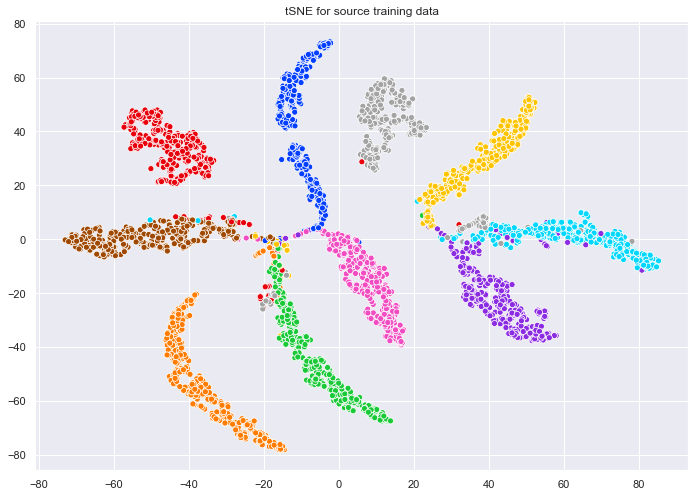

In [22]:
# Evalualtion

from sklearn.manifold import TSNE
import seaborn as sns

source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source training data')


 36%|███▌      | 9/25 [00:00<00:00, 17.32it/s]


Text(0.5, 1.0, 'tSNE for source testing data')

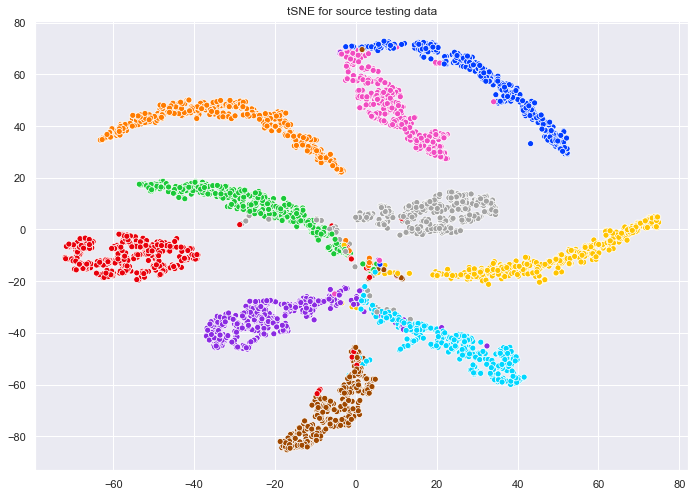

In [23]:
source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(test_mnist_loader), total=len(test_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source testing data')
